In [1]:
import numpy as np
import pandas as pd

In [2]:
from collections import defaultdict

In [3]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [4]:
# ratings = ratings[ratings['userId'].isin( ratings['userId'].value_counts().head(10).index )]

In [5]:
ratings = ratings.groupby('userId' , group_keys=False ).apply( lambda x : x.sample(frac=.5) )

In [6]:
ratings.head(2)

,userId,movieId,rating,timestamp
101,1,1580,3.0,964981125
150,1,2366,4.0,964982462


In [7]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [8]:
print( ratings.shape )
print( movies.shape )

(50420, 4)
(9742, 3)


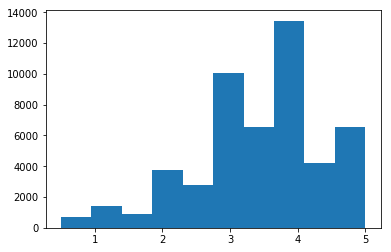

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist( ratings['rating'])
plt.show()

In [9]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise import Dataset ,Reader 

from surprise.model_selection import train_test_split , LeaveOneOut


In [10]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [11]:
[trainset , testset] = train_test_split( data , test_size = .15 , shuffle = True )

In [12]:
algo = SVD(random_state = 0 )
algo.fit( trainset )
predictions = algo.test( testset )

In [13]:
from ipynb.fs.full.EvaluationMetrics import RecommendationMetrics

# Basic Validation

In [61]:
print( 'Evaluating accuracy of model')
print()
print('RMSE of the Model : ',RecommendationMetrics.RMSE(predictions) )
print('MAE of the Model : ',RecommendationMetrics.MAE(predictions) )

Evaluating accuracy of model

RMSE of the Model :  0.9021972678611864
MAE of the Model :  0.6945431713576792


# Cross Validation to check how the model will perform for different dataset 

In [97]:
from surprise.model_selection import cross_validate
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8913  0.8859  0.8998  0.8973  0.9108  0.8970  0.0084  
MAE (testset)     0.6864  0.6843  0.6905  0.6924  0.6973  0.6902  0.0046  
Fit time          4.17    4.13    4.25    4.38    4.28    4.24    0.09    
Test time         0.10    0.09    0.09    0.11    0.10    0.10    0.00    


{'test_rmse': array([0.89125499, 0.88587363, 0.89979079, 0.89734809, 0.9107955 ]),
 'test_mae': array([0.68637631, 0.68426296, 0.69053933, 0.69241317, 0.69730692]),
 'fit_time': (4.17397665977478,
  4.129962682723999,
  4.252964735031128,
  4.379033803939819,
  4.277015209197998),
 'test_time': (0.09702110290527344,
  0.09402251243591309,
  0.09400105476379395,
  0.10500073432922363,
  0.09500265121459961)}

# TopN Validations techniques

In [98]:
LOOCV = LeaveOneOut(n_splits=1 , random_state = 0 )

for trainset , testset in LOOCV.split(data):
    
    print('Computing Recommendation with leave-one-out model')
    algo.fit( trainset )
    
    print('predicting ratings for left out set')
    leftOutPrediction = algo.test( testset )
    
    print('Predict all missing ratings')
    bigTestSet = trainset.build_anti_testset()
    allpredictions = algo.test( bigTestSet )
    
    print('Compute Top 10 recommendation per User')
    topNPredicted = RecommendationMetrics.GetTopN( allpredictions , n = 10 )
    
    print('\nHit Rate:' , RecommendationMetrics.HitRate(topNPredicted, leftOutPrediction) )
    
    print('\nARHR(Average Reciprocal Hit Rate Value ) :' , RecommendationMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPrediction) )
    
    print('\ncHR(Cummulative Hit Rate Value ) :' , RecommendationMetrics.CumulativeHitRate(topNPredicted, leftOutPrediction, ratingCutoff=4) )
    
    print('\nrHR(Hit Rate by rating value ) :' )
    RecommendationMetrics.RatingHitRate(topNPredicted, leftOutPrediction) 


Computing Recommendation with leave-one-out model
predicting ratings for left out set
Predict all missing ratings
Compute Top 10 recommendation per User

Hit Rate: 0.021311475409836064

ARHR(Average Reciprocal Hit Rate Value ) : 0.005766978922716629

cHR(Cummulative Hit Rate Value ) : 0.03560830860534125

rHR(Hit Rate by rating value ) :
3.5 0.019230769230769232
4.0 0.017241379310344827
4.5 0.01818181818181818
5.0 0.07407407407407407


In [14]:
fullTrainSet = data.build_full_trainset()
algo.fit( fullTrainSet )
bigTestSet = fullTrainSet.build_anti_testset()

allPredictions = algo.test( bigTestSet )
topNPredicted = RecommendationMetrics.GetTopN( allPredictions , n = 10 )

In [15]:
print('User Coverage :' , RecommendationMetrics.UserCoverage( topNPredicted ,fullTrainSet.n_users, ratingThreshold=4) )

User Coverage : 0.9229508196721311


In [16]:
from surprise import KNNWithMeans
simsAlgo = KNNWithMeans( k=30 , sim_options = {'name' : 'cosine' , 'user_based' : False } )
simsAlgo.fit( fullTrainSet )

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [17]:
print('Diversity : ' , RecommendationMetrics.Diversity( topNPredicted , simsAlgo ) )

Computing the cosine similarity matrix...
Done computing similarity matrix.
Diversity :  1.0


In [18]:
popularity = ratings.groupby('movieId').agg({'userId':'count'}).sort_values('userId' , ascending = False)
popularity['rank'] = popularity['userId'].rank(method='first', ascending=False  )
ranking = popularity['rank'].to_dict()

In [19]:
print( 'Novelty (average popularity Rank) : ' , RecommendationMetrics.Novelty( topNPredicted , ranking ) )

Novelty (average popularity Rank) :  257.2637571157495
